# Orçamento de Estado de 2022

```{epigraph}
Cursum perficio \
 \
Verbum sapienti (eo plus cupiunt) \
Verbum sapienti \
Quo plus habent, eo plus cupiunt \
Verbum sapienti \
Quo plus habent, eo plus cupiunt \
 \
Post nubila, Phoebus \
Post nubila, Phoebus \
Post nubila, Phoebus \
-- Enya, «Cursum perficio»
```

A análise das votações e posicionamento relativo dos partidos tendo como base *exclusivamente* a forma como votam foi a base do trabalho anterior, análise essa que teve como fonte as votações das Iniciativas e Actividades.

O Orçamento de Estado para 2022 que aqui analisamos é fruto de um processo longo e que resulta do chumbo da sua primeira versão, por falta de apoio parlamentar à proposta do governo minoritário do PS; durante um período de negociações com os vários parceiros "à esquerda" não foi conseguido o apoio suficiente para a aprovação: o BE desde cedo indicou não existirem condições para a viabilização, enquanto PEV e PCP (que tinham sido fundamentais para a aprovação do OE de 2021, já com a oposição do BE) continuam as negociações (sabe-se hoje) com o Governo até ao dia da votação mas sem que seja atingido o mínimo considerado necessário para a aprovação na generalidade.

A abstenção do PAN e das duas deputadas não inscritas (Joacine Katar Moreira, ex-Livre) e Cristina Rodrigues (ex-PAN) não foram suficientes para a aprovação, que levou ao chumbo do OE. Das opções existentes, o Presidente da República optou pela dissolução do Parlamento e convocação de eleições antecipadas, que resultariam numa maioria absoluta do PS, enfraquecimento de BE e PCP, crescimento de IL e CH e desaparecimento das bancadas parlamentos do CDS-PP e do PEV.

É neste contexto de maioria absoluta que as votações das propostas de alteração são feitas.

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos)

São fundamentalmente feitas as seguintes análises:

1. Quantidade e tipo de propostas feitas, e resultado das mesmas
2. Apoio para as propostas de cada partido
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)

In [42]:
!pip3 install --user -q  matplotlib pandas seaborn sklearn 

%matplotlib inline

In [43]:
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme(style="whitegrid", palette="pastel")

In [44]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

oe_url = "http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379395063734f6e5957316c626e52764a5449775a47386c4d6a4246633352685a47387657456c574a5449775447566e61584e7359585231636d457654305651636d397762334e3059584e426248526c636d466a595738794d4449785433497565473173&fich=OEPropostasAlteracao2021Or.xml&Inline=true"
#oe_tree = ET.parse(urlopen(oe_url))
oe_file = './OEPropostasAlteracao2022Or.xml'
oe_tree = ET.parse(oe_file)

In [45]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

        oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print(vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [46]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df

ID       Nr                 Date Domain  \
0     17153    1398C  13/05/2022 20:27:00   None   
1     17152    1397C  13/05/2022 20:27:00   None   
2     17202  1396C-2  13/05/2022 20:14:00   None   
3     17151  1396C-1  13/05/2022 20:14:00   None   
4     17149    1395C  13/05/2022 20:12:00   None   
...     ...      ...                  ...    ...   
1500  14712      13C  02/05/2022 09:02:00   None   
1501  14711      12C  02/05/2022 09:02:00   None   
1502  14710      11C  02/05/2022 09:02:00   None   
1503  14709      10C  02/05/2022 09:02:00   None   
1504  14708       9C  02/05/2022 09:01:00   None   

                                Type                     State   GP  \
0            Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PSD   
1            Aditamento (Artigo PPL)               Retirado(a)  PSD   
2     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
3                       Substituição   Aprovado(a) em Comissão   PS   
4            Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PAN   
...                              ...                       ...  ...   
1500         Aditamento (Artigo PPL)  Rejeitado(a) em Plenário  PCP   
1501                    Substituição  Rejeitado(a) em Comissão  PCP   
1502                    Substituição  Rejeitado(a) em Plenário  PCP   
1503         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PCP   
1504         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PCP   

                                               IniTitle              VoteDesc  \
0     Criação de um Fundo de Garantia Mútua para o S...        Artigo 177.º-A   
1     Estudo do impacto da produtividade e bem-estar...                   NaN   
2               Utentes inscritos por médico de família  N.º 11, Artigo 179.º   
3               Utentes inscritos por médico de família   N.º 5, Artigo 179.º   
4                     Transporte não urgente de doentes          Artigo 9.º-A   
...                                                 ...                   ...   
1500            Alargamento da gratuitidade das creches        Artigo 115.º-A   
1501                          Regime de dedicação plena           Artigo 38.º   
1502              Atualização extraordinária de pensões    N.º 2, Artigo 60.º   
1503  Suplemento por serviço e risco nas forças de s...         Artigo 31.º-A   
1504   Eliminação do aumento das taxas unitárias do ISP        Artigo 234.º-A   

     Partido Socialista  ... Iniciativa Liberal Partido Comunista Português  \
0                Contra  ...             Contra                   Abstenção   
1                   NaN  ...                NaN                         NaN   
2                 Favor  ...          Abstenção                       Favor   
3                 Favor  ...          Abstenção                   Abstenção   
4                Contra  ...              Favor                       Favor   
...                 ...  ...                ...                         ...   
1500             Contra  ...             Contra                       Favor   
1501             Contra  ...             Contra                       Favor   
1502             Contra  ...             Contra                       Favor   
1503             Contra  ...          Abstenção                       Favor   
1504             Contra  ...              Favor                       Favor   

     Bloco de Esquerda Pessoas-Animais-Natureza               V_Date  \
0            Abstenção                    Favor  24/05/2022 00:00:00   
1                  NaN                      NaN                  NaN   
2            Abstenção                    Favor  24/05/2022 00:00:00   
3            Abstenção                    Favor  24/05/2022 00:00:00   
4                Favor                    Favor  24/05/2022 00:00:00   
...                ...                      ...                  ...   
1500             Favor                    Favor  25/05/2022 00:00:00   
1501             Favor           

## As propostas: quantidade, aprovações, rejeições

Após obtermos e processarmos o ficheiro com as Propostas de Alteração podemos ter uma primeira ideia sobre a origem das propostas:

```{margin}
Em gráfico de barras:
```

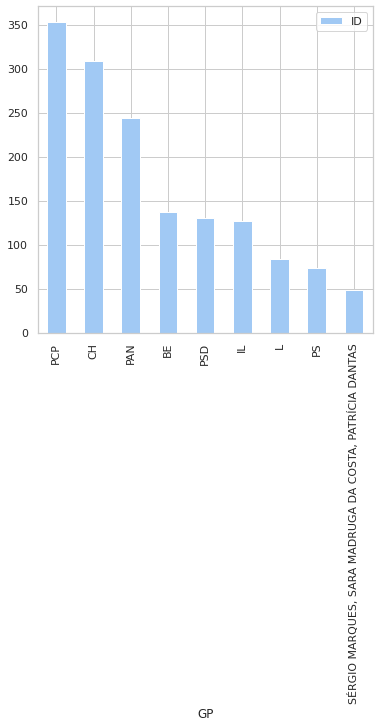

In [47]:
oe_df.groupby('GP')[['ID']].count().sort_values(by=['ID'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))
plt.show()


In [7]:
oe_df.groupby('GP')[['ID']].count().sort_values("ID", ascending=False)

ID
GP                                                     
PCP                                                 353
CH                                                  309
PAN                                                 244
BE                                                  137
PSD                                                 130
IL                                                  127
L                                                    84
PS                                                   73
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...   48

O resultado das propostas de cada partido (ou seja, se e como foram aprovadas ou rejeitadas):

In [48]:
pd.crosstab(oe_df.GP, oe_df.State)

State                                               Aguarda Voto em Comissão  \
GP                                                                             
BE                                                                         0   
CH                                                                         2   
IL                                                                         0   
L                                                                          0   
PAN                                                                        0   
PCP                                                                        0   
PS                                                                         0   
PSD                                                                        0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                         0   

State                                               Aprovado(a) Parcialmente em Comissão  \
GP                                                                                         
BE                                                                                     1   
CH                                                                                     0   
IL                                                                                     0   
L                                                                                      0   
PAN                                                                                    1   
PCP                                                                                    1   
PS                                                                                     0   
PSD                                                                                    0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                     0   

State                                               Aprovado(a) Parcialmente em Plenário  \
GP                                                                                         
BE                                                                                     0   
CH                                                                                     0   
IL                                                                                     1   
L                                                                                      0   
PAN                                                                                    0   
PCP                                                                                    0   
PS                                                                                     0   
PSD                                                                                    0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                     0   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                        1   
CH                                                                        0   
IL                                                                        0   
L                                                                        10   
PAN                                                                      37   
PCP                                                                       0   
PS                                                                       51   
PSD                                                                       1   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        4   

State                                               Aprovado(a) em Plenário  \
GP                                                                            
BE                                                               

Em relação ao OE de 2021 notam-se algumas contantes (PCP como partido com maior número de propostas a mais óbvia) mas também algumas diferenças: desde logo a muito maior quantidade de propostas do BE (137 vs. 12), a duplicação das propostas do CH (que agora ultrapassam as 300 e o colocam em segundo lugar em número de propostas) e, claro, a diferente composição do Parlamento com o desaparecimento de propostas de CDS-PP, PEV, Joacine Katar Moreira (que tinha um número de propostas não muito inferior às de Rui Tavares) e Cristina Rodrigues (que abandonou o Parlamento e se tornou acessora parlamento do CH). A IL, com significativamente mais deputados, tem um número de propostas ligeiramente maior do que quando tinha apenas o deputado único Cotrim Figueiredo.

In [49]:
pd.crosstab(oe_df.GP, oe_df.State).columns

ct = pd.crosstab(oe_df.GP, oe_df.State)[['Aprovado(a) por Unanimidade em Plenário',
                                         'Aprovado(a) por Unanimidade em Comissão',
                                         'Aprovado(a) em Plenário',
                                         'Aprovado(a) em Comissão',
                                         'Aprovado(a) Parcialmente em Plenário',
                                         'Aprovado(a) Parcialmente em Comissão',
                                         'Retirado(a)',
                                         'Prejudicado(a)',
                                         'Rejeitado(a) em Plenário',
                                         'Rejeitado(a) em Comissão'
                                        ]]
ct

State                                               Aprovado(a) por Unanimidade em Plenário  \
GP                                                                                            
BE                                                                                        0   
CH                                                                                        0   
IL                                                                                        0   
L                                                                                         0   
PAN                                                                                       0   
PCP                                                                                       0   
PS                                                                                        1   
PSD                                                                                       0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                        0   

State                                               Aprovado(a) por Unanimidade em Comissão  \
GP                                                                                            
BE                                                                                        0   
CH                                                                                        0   
IL                                                                                        2   
L                                                                                         1   
PAN                                                                                       3   
PCP                                                                                       0   
PS                                                                                        5   
PSD                                                                                       2   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                                        1   

State                                               Aprovado(a) em Plenário  \
GP                                                                            
BE                                                                        0   
CH                                                                        0   
IL                                                                        0   
L                                                                         2   
PAN                                                                       0   
PCP                                                                       0   
PS                                                                       12   
PSD                                                                       0   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        0   

State                                               Aprovado(a) em Comissão  \
GP                                                                            
BE                                                                        1   
CH                                                                        0   
IL                                                                        0   
L                                                                        10   
PAN                                                                      37   
PCP                                                                       0   
PS                                                                       51   
PSD                                                                       1   
SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA...                        4   

State                                               Aprovado(a) Parcialmente em Plenário  \
GP                                                                          

A mesma informação em forma de gráfico de barras: o total de propostas de cada partido (ou deputados) com a distribuição do resultado das mesmas, ordenados pelo maior número de aprovações.

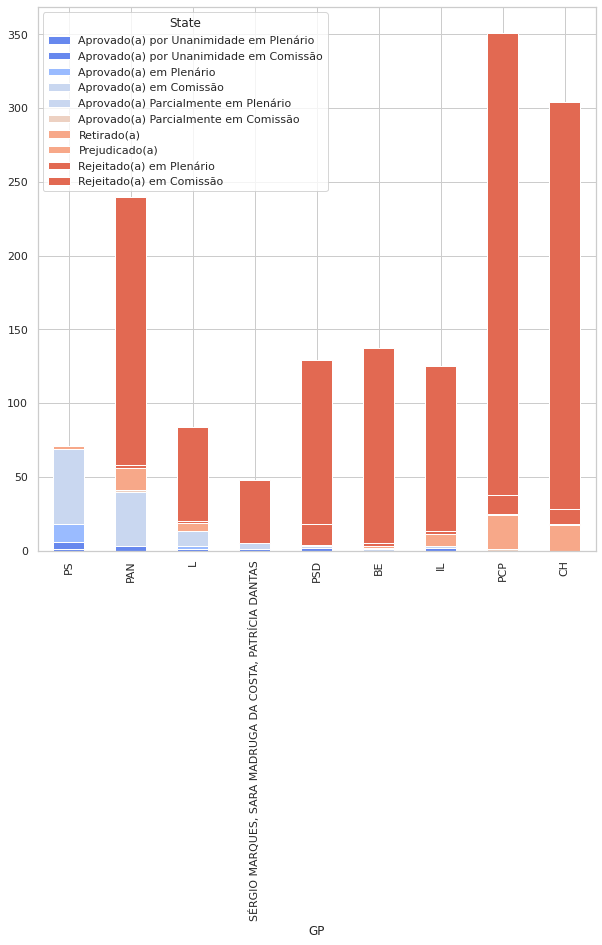

In [75]:
%matplotlib inline
#    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set()
sns.set_style("whitegrid")

## Sort by the "Approved" in the many ways it's possible
## sort by a separate aggregate value.
ct.sort_values(by=['Aprovado(a) em Comissão','Aprovado(a) por Unanimidade em Comissão','Aprovado(a) em Plenário','Aprovado(a) Parcialmente em Plenário','Aprovado(a) por Unanimidade em Plenário','Aprovado(a) Parcialmente em Comissão'], ascending=False,axis=0).plot(kind="bar", stacked=True, colormap=ListedColormap(sns.color_palette("coolwarm").as_hex()),figsize=(10,10))
plt.show()

Olhando para este gráfico, algumas possíveis leituras:

* O maior número de propostas submetidas e também rejeitadas é do PCP.
* CH não consegue aprovação de nenhuma proposta, sendo o segundo partido com maior número de propostas.
* PS, PAN e Livre são os que conseguem maior número de propostas aprovadas.
* O PS é o que tem uma percentagem de aprovação maior (quase total, apenas não completa por propostas retiradas).
* Os restantes partidos têm um conjunto residual de propostas aprovadas.

A maioria absoluta do PS não pode ser separada destes resultados, havendo uma quase completa inversão de alguns factores relativamente ao orçamento anterior, bem como uma aparente convergência (dentro do contexto) com PAN e Livre.

### Propostas aprovadas

E que propostas cada partido conseguiu aprovar? A utilização do título da iniciativa é aqui útil

In [76]:
from IPython.display import display, HTML

approved_oe = oe_df[oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ":", len(gp_df.index), " aprovadas.")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)



PS: 70  aprovadas.


GP  \
2    PS   
3    PS   
5    PS   
6    PS   
7    PS   
8    PS   
16   PS   
17   PS   
33   PS   
76   PS   
78   PS   
285  PS   
291  PS   
293  PS   
298  PS   
299  PS   
300  PS   
301  PS   
304  PS   
313  PS   
316  PS   
319  PS   
320  PS   
322  PS   
324  PS   
329  PS   
330  PS   
332  PS   
333  PS   
336  PS   
337  PS   
343  PS   
344  PS   
347  PS   
353  PS   
354  PS   
355  PS   
359  PS   
362  PS   
363  PS   
369  PS   
374  PS   
377  PS   
379  PS   
380  PS   
382  PS   
383  PS   
386  PS   
387  PS   
395  PS   
397  PS   
400  PS   
406  PS   
411  PS   
416  PS   
418  PS   
419  PS   
422  PS   
423  PS   
425  PS   
426  PS   
428  PS   
432  PS   
433  PS   
438  PS   
440  PS   
444  PS   
452  PS   
453  PS   
462  PS   

                                                                                                                              IniTitle  \
2    Utentes inscritos por médico de família                                                                                             
3    Utentes inscritos por médico de família                                                                                             
5    Transferências orçamentais                                                                                                          
6    Utilização de viaturas de serviço                                                                                                   
7    Programas operacionais que integram o Portugal 2020, o Portugal 2030 e a Estrutura de Missão «Recuperar Portugal»                   
8    Programas operacionais que integram o Portugal 2020, o Portugal 2030 e a Estrutura de Missão «Recuperar Portugal»                   
16   Fundo de Financiamento da Descentralização e transferências financeiras ao abrigo da descentralização e delegação de competências   
17   Fundo de Financiamento da Descentralização e transferências financeiras ao abrigo da descentralização e delegação de competências   
33   Vinculação de trabalhadores dos serviços de abastecimento de água e de saneamento de águas residuais                                
76   Proteção social complementar dos trabalhadores em regime de contrato individual de trabalho                                         
78   Norma revogatória e de produção de efeitos em matéria fiscal                                                                        
285  Alteração à Lei n.º 70/2021, de 4 de novembro                                                                                       
291  Regime Especial de Imposto sobre Veículos                                                                                           
293  Montantes da participação das autarquias locais nos impostos do Estado                                                              
298  Incentivo fiscal à recuperação                                                                                                      
299  Norma revogatória e de produção de efeitos em matéria fiscal                                                                        
300  Alteração ao Código de Processo Civil                                                                                               
301  Alteração ao Código de Procedimento e de Processo Tributário                                                                        
304  Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis                                                  
313  Introdução no consumo e comercialização de produtos do tabaco                                                                       
316  Empréstimos dos municípios para habitação e operações de reabilitação urbana                                                        
319  Alteração ao Código do Imposto Único de Circulação                                                                                  
320  Alteração ao Código do Imposto sobre Veículo

PAN: 41  aprovadas.


GP  \
30    PAN   
36    PAN   
41    PAN   
45    PAN   
46    PAN   
61    PAN   
66    PAN   
70    PAN   
74    PAN   
122   PAN   
126   PAN   
162   PAN   
224   PAN   
469   PAN   
575   PAN   
597   PAN   
600   PAN   
627   PAN   
786   PAN   
793   PAN   
1072  PAN   
1075  PAN   
1179  PAN   
1209  PAN   
1231  PAN   
1298  PAN   
1302  PAN   
1361  PAN   
1387  PAN   
1389  PAN   
1394  PAN   
1401  PAN   
1406  PAN   
1441  PAN   
1447  PAN   
1459  PAN   
1461  PAN   
1467  PAN   
1468  PAN   
1469  PAN   
1470  PAN   

                                                                                                    IniTitle  \
30    Reconhecimento do capital natural como valor económico de um país                                        
36    Bolsa de Horas dos intérpretes de língua gestual no ensino obrigatório                                   
41    Rede de respostas para pessoas com deficiência maiores de idade                                          
45    Acessibilidade aos transportes públicos por pessoas invisuais                                            
46    Proteção dos tubarões                                                                                    
61    Relatório sobre a qualidade do alojamento no Ensino Superior                                             
66    Centro de investigação com recurso a modelos alternativos aos animais utilizados para fins científicos   
70    Interdição do chumbo na pesca                                                                            
74    Revisão do Programa “Remuneração dos Serviços dos Ecossistemas em Espaços Rurais”                        
122   Incentivos ao adequado descarte de produtos de tabaco                                                    
126   Respostas transitórias para apoio a vítimas de tráfico de seres humanos                                  
162   Apoio técnico e financeiro ao combate às práticas tradicionais nefastas                                  
224   Realização de Censos sobre espécies cinegéticas                                                          
469   Apoio à criação de espaços de acolhimento de animais de grande porte e criação do regime jurídico        
575   Alteração ao regime jurídico de identificação dos animais de companhia                                   
597   Refeições vegetarianas nas cantinas públicas                                                             
600   Gestão sustentável de habitats agrícolas                                                                 
627   Interdição de caça em terrenos geridos pela Florestgal                                                   
786   Apoios ao investimento para a agricultura biológica                                                      
793   Programa de monitorização, gestão e remoção de resíduos de artes de pesca                                
1072  Incentivo à plantação de espécies autóctones                                                             
1075  Requalificação e Musealização da Casa do Passal                                                          
1179  Resposta Integrada de Apoio à Vítima                                                                     
1209  Interdição da utilização de chumbo nas munições da atividade cinegética                                  
1231  Combate à pobreza energética e adaptação das habitações às alterações climáticas                         
1298  Reforço das medidas de segurança em contexto universitário                                               
1302  Transparência na execução do Orçamento do Estado                                                         
1361  Incentivo aos hábitos de leitura nos jovens adultos                                                      
1387  Centros de Recuperação de Animais Selvagens                                                              
1389  Transparência do financiamento público a associações e demais entidades de direito privado    

PSD: 3  aprovadas.


GP  \
53   PSD   
710  PSD   
724  PSD   

                                                                                              IniTitle  \
53   Suspensão da fixação de contingente global para efeitos de concessão de autorização de residência   
710  Alteração ao Código do Imposto do Selo                                                              
724  Reforço do combate à corrupção, fraude e criminalidade económico-financeira                         

                          VoteDesc                                    State  
53   Artigo 139.º                   Aprovado(a) em Comissão                  
710  Artigo 231.º                   Aprovado(a) por Unanimidade em Comissão  
724  Alínea a), N.º 1, Artigo 24.º  Aprovado(a) por Unanimidade em Comissão

IL: 3  aprovadas.


GP  \
159  IL   
783  IL   
785  IL   

                                                                                                       IniTitle  \
159  Antecipação das decisões sobre atribuição de bolsas de estudo no Ensino Superior                             
783  Reforço da formação para o combate à violência doméstica e no namoro                                         
785  Reforço da formação dos magistrados para o combate aos crimes contra a liberdade e autodeterminação sexual   

               VoteDesc                                    State  
159  Artigo 172.º-A      Aprovado(a) Parcialmente em Plenário     
783  N.º 4, Artigo 47.º  Aprovado(a) por Unanimidade em Comissão  
785  Artigo 47.º-A       Aprovado(a) por Unanimidade em Comissão

L: 13  aprovadas.


GP  \
253   L   
262   L   
454   L   
470   L   
496   L   
632   L   
1471  L   
1472  L   
1473  L   
1474  L   
1482  L   
1484  L   
1487  L   

                                                                                  IniTitle  \
253   Estudo sobre impacto da menstruação no trabalho e na qualidade de vida e em Portugal   
262   Reforço das juntas médicas                                                             
454   Reconversão de veículos a combustão para utilização de energias limpas                 
470   Formação sobre questões e identidades LGBTQIA+                                         
496   Alteração à lista I anexa ao Código do Imposto sobre o Valor Acrescentado              
632   Formação em Direitos Humanos e em acolhimento de refugiados e migrantes                
1471  Licença para formação                                                                  
1472  Alargamento do subsídio de desemprego                                                  
1473  Corpo da Guarda Prisional                                                              
1474  Admissões nas forças e serviços de segurança                                           
1482  Fundo Ambiental                                                                        
1484  Eficiência energética e conforto térmico                                               
1487  Novos modelos de organização do trabalho                                               

                 VoteDesc                                    State  
253   Artigo 143.º-A       Aprovado(a) em Comissão                  
262   Artigo 112.º-A       Aprovado(a) por Unanimidade em Comissão  
454   Artigo 198.º-A       Aprovado(a) em Comissão                  
470   Artigo 178.º-B       Aprovado(a) em Comissão                  
496   Artigo 227.º-B       Aprovado(a) em Comissão                  
632   Artigo 47.º-A        Aprovado(a) em Comissão                  
1471  Artigo 99.º-B        Aprovado(a) em Plenário                  
1472  Artigo 99.º-A        Aprovado(a) em Plenário                  
1473  N.º 2, Artigo 33.º   Aprovado(a) em Comissão                  
1474  N.º 2, Artigo 31.º   Aprovado(a) em Comissão                  
1482  N.º 3, Artigo 194.º  Aprovado(a) em Comissão                  
1484  Artigo 194.º-A       Aprovado(a) em Comissão                  
1487  Artigo 177.º-A       Aprovado(a) em Comissão

BE: 2  aprovadas.


GP  \
429  BE   
617  BE   

                                                                  IniTitle  \
429  Medidas para combater a pobreza menstrual                               
617  Programa de promoção do Estatuto dos Profissionais da Área da Cultura   

           VoteDesc                                 State  
429  Artigo 180.º-A  Aprovado(a) Parcialmente em Comissão  
617  Artigo 168.º-A  Aprovado(a) em Comissão

SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS: 5  aprovadas.


GP  \
494   SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS   
522   SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS   
549   SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS   
1323  SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS   
1324  SÉRGIO MARQUES, SARA MADRUGA DA COSTA, PATRÍCIA DANTAS   

                                                          IniTitle  \
494   Alteração ao Código dos Impostos Especiais de Consumo          
522   Imputação de Receitas Fiscais às Regiões Autónomas             
549   Limites máximos para a concessão de garantias                  
1323  Norma revogatória e de produção de efeitos em matéria fiscal   
1324  Alteração ao Estatuto dos Benefícios Fiscais                   

                 VoteDesc                                    State  
494                        Aprovado(a) em Comissão                  
522   Artigo 62.º-A        Aprovado(a) por Unanimidade em Comissão  
549   N.º 8, Artigo 123.º  Aprovado(a) em Comissão                  
1323  N.º 6, Artigo 261.º  Aprovado(a) em Comissão                  
1324                       Aprovado(a) em Comissão

PCP: 1  aprovadas.


GP                                             IniTitle  \
1183  PCP  Preferência de venda de imóveis a Autarquias Locais   

            VoteDesc                                 State  
1183  Artigo 205.º-A  Aprovado(a) Parcialmente em Comissão

### Propostas rejeitadas

Da mesma forma podemos obter a lista de propostas rejeitas, por partido.

## As votações

Até agora contabilizámos as propostas de alteração e o seu resultado; se em geral existe uma votação por proposta de alteração isso nem sempre acontece: existem propostas de alteração que dão origem a mais que uma votação. As votações contêm informação adicional que é interessante para de determinar de forma directa o teor das propostas (nomeadamente o título) e também a forma como os diferentes partidos e deputados votaram: se ao nível das propostas temos o resultado final, com as votações podemos saber como atingiram esse fim.

Após processarmos as votações enriquecemos o _dataframe_ com informação adicional. do qual a seguinte selecção é um exemplo: note-se o maior numero de colunas com informação adicional sobre cada votação.

In [78]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.getroot().findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "SubDescricao":
                    oe_dict["SubDesc"] = vote_el.text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

            oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print("Voting sessions:", vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [79]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df
oe_df["VoteDesc"] = oe_df["VoteDesc"] + ": " + oe_df["SubDesc"]
oe_df.drop(['SubDesc'],axis=1,inplace=True)
oe_df

ID       Nr                 Date Domain  \
0     17153    1398C  13/05/2022 20:27:00   None   
1     17202  1396C-2  13/05/2022 20:14:00   None   
2     17202  1396C-2  13/05/2022 20:14:00   None   
3     17202  1396C-2  13/05/2022 20:14:00   None   
4     17202  1396C-2  13/05/2022 20:14:00   None   
...     ...      ...                  ...    ...   
1534  14711      12C  02/05/2022 09:02:00   None   
1535  14710      11C  02/05/2022 09:02:00   None   
1536  14710      11C  02/05/2022 09:02:00   None   
1537  14709      10C  02/05/2022 09:02:00   None   
1538  14708       9C  02/05/2022 09:01:00   None   

                                Type                     State   GP  \
0            Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PSD   
1     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
2     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
3     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
4     Aditamento (Números e Alíneas)   Aprovado(a) em Comissão   PS   
...                              ...                       ...  ...   
1534                    Substituição  Rejeitado(a) em Comissão  PCP   
1535                    Substituição  Rejeitado(a) em Plenário  PCP   
1536                    Substituição  Rejeitado(a) em Plenário  PCP   
1537         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PCP   
1538         Aditamento (Artigo PPL)  Rejeitado(a) em Comissão  PCP   

                                               IniTitle  \
0     Criação de um Fundo de Garantia Mútua para o S...   
1               Utentes inscritos por médico de família   
2               Utentes inscritos por médico de família   
3               Utentes inscritos por médico de família   
4               Utentes inscritos por médico de família   
...                                                 ...   
1534                          Regime de dedicação plena   
1535              Atualização extraordinária de pensões   
1536              Atualização extraordinária de pensões   
1537  Suplemento por serviço e risco nas forças de s...   
1538   Eliminação do aumento das taxas unitárias do ISP   

                                               VoteDesc Partido Socialista  \
0     Artigo 177.º-A: Criação de um Fundo de Garanti...             Contra   
1                                                   NaN              Favor   
2                                                   NaN              Favor   
3                                                   NaN              Favor   
4                                                   NaN              Favor   
...                                                 ...                ...   
1534             Artigo 38.º: Regime de dedicação plena             Contra   
1535                                                NaN             Contra   
1536                                                NaN             Contra   
1537  Artigo 31.º-A: Suplemento por serviço e risco ...             Contra   
1538  Artigo 234.º-A: Eliminação do aumento das taxa...             Contra   

      ... Iniciativa Liberal Partido Comunista Português Bloco de Esquerda  \
0     ...             Contra                   Abstenção         Abstenção   
1     ...          Abstenção                       Favor         Abstenção   
2     ...          Abstenção                       Favor         Abstenção   
3     ...          Abstenção                       Favor         Abstenção   
4     ...          Abstenção                       Favor         Abstenção   
...   ...                ...                         ...               ...   
1534  ...             Contra                       Favor             Favor   
1535  ...             Contra                       Favor             Favor   
1536  ...             Contra                       Favor             Favor   
1537  ...          Abstenção                       Favor             Favor   
1538  ...              Favo

In [109]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
oe_dfr = oe_df.rename(columns={'Partido Socialista': 'PS', 
                               'Partido Social Democrata': 'PSD',
                               'Bloco de Esquerda': 'BE',
                               'Partido Comunista Português': 'PCP',
                               'Pessoas-Animais-Natureza': 'PAN',
                               'Chega': 'CH',
                               'Iniciativa Liberal':'IL',
                               'Livre':'L',                               
                              })
oe_dfr.head()


ID       Nr                 Date Domain                            Type  \
0  17153    1398C  13/05/2022 20:27:00   None         Aditamento (Artigo PPL)   
1  17202  1396C-2  13/05/2022 20:14:00   None  Aditamento (Números e Alíneas)   
2  17202  1396C-2  13/05/2022 20:14:00   None  Aditamento (Números e Alíneas)   
3  17202  1396C-2  13/05/2022 20:14:00   None  Aditamento (Números e Alíneas)   
4  17202  1396C-2  13/05/2022 20:14:00   None  Aditamento (Números e Alíneas)   

                      State   GP  \
0  Rejeitado(a) em Comissão  PSD   
1   Aprovado(a) em Comissão   PS   
2   Aprovado(a) em Comissão   PS   
3   Aprovado(a) em Comissão   PS   
4   Aprovado(a) em Comissão   PS   

                                            IniTitle  \
0  Criação de um Fundo de Garantia Mútua para o S...   
1            Utentes inscritos por médico de família   
2            Utentes inscritos por médico de família   
3            Utentes inscritos por médico de família   
4            Utentes inscritos por médico de família   

                                            VoteDesc      PS  ...         IL  \
0  Artigo 177.º-A: Criação de um Fundo de Garanti...  Contra  ...     Contra   
1                                                NaN   Favor  ...  Abstenção   
2                                                NaN   Favor  ...  Abstenção   
3                                                NaN   Favor  ...  Abstenção   
4                                                NaN   Favor  ...  Abstenção   

         PCP         BE    PAN               V_Date        Result    L  \
0  Abstenção  Abstenção  Favor  24/05/2022 00:00:00  Rejeitado(a)  NaN   
1      Favor  Abstenção  Favor  24/05/2022 00:00:00   Aprovado(a)  NaN   
2      Favor  Abstenção  Favor  24/05/2022 00:00:00   Aprovado(a)  NaN   
3      Favor  Abstenção  Favor  24/05/2022 00:00:00   Aprovado(a)  NaN   
4      Favor  Abstenção  Favor  24/05/2022 00:00:00   Aprovado(a)  NaN   

  PATRÍCIA DANTAS(PSD) SÉRGIO MARQUES(PSD) SARA MADRUGA DA COSTA(PSD)  
0                  NaN                 NaN                        NaN  
1                  NaN                 NaN                        NaN  
2                  NaN                 NaN                        NaN  
3                  NaN                 NaN                        NaN  
4                  NaN                 NaN                        NaN  

[5 rows x 22 columns]

Para a análise das votações escolhemos um subconjunto alargado dos autores das propostas, isto porque as propostas de deputados individuais ou em grupo necessitaria de um tratamento mais complexo: consideramos todos os grupos parlamentos e deputados únicos de partido (Livre).

O resultado é uma tabela com a indicação do autor da proposta onde se integra a votação e os votos dos partidos.

```{margin} Votações, partidos e Comissões
Devido à forma  de funcionamento das Comissões, o Livere não estará presente em várias delas, resultando num número elevado de ausências (>80%). Optámos pela sua não inclusão nesta análise pela pouca representatividade dos dados.
```

In [110]:
mycol  = ['GP', 'BE', 'PCP','L','PS', 'PAN', 'PSD','IL', 'CH' ]
parties   = ['BE', 'PCP','L','PS', 'PAN','PSD','IL', 'CH']
df=oe_dfr

submissions_ini = df[mycol]
submissions_ini.head()

GP         BE        PCP    L      PS    PAN        PSD         IL      CH
0  PSD  Abstenção  Abstenção  NaN  Contra  Favor      Favor     Contra  Contra
1   PS  Abstenção      Favor  NaN   Favor  Favor  Abstenção  Abstenção   Favor
2   PS  Abstenção      Favor  NaN   Favor  Favor  Abstenção  Abstenção   Favor
3   PS  Abstenção      Favor  NaN   Favor  Favor  Abstenção  Abstenção   Favor
4   PS  Abstenção      Favor  NaN   Favor  Favor  Abstenção  Abstenção   Favor

Com esta informação é possível determinar os padrões de votação; o diagrama seguinte mostra a relação entre cada par de partidos: no eixo horizontal quem propõe, e no vertical como votaram:

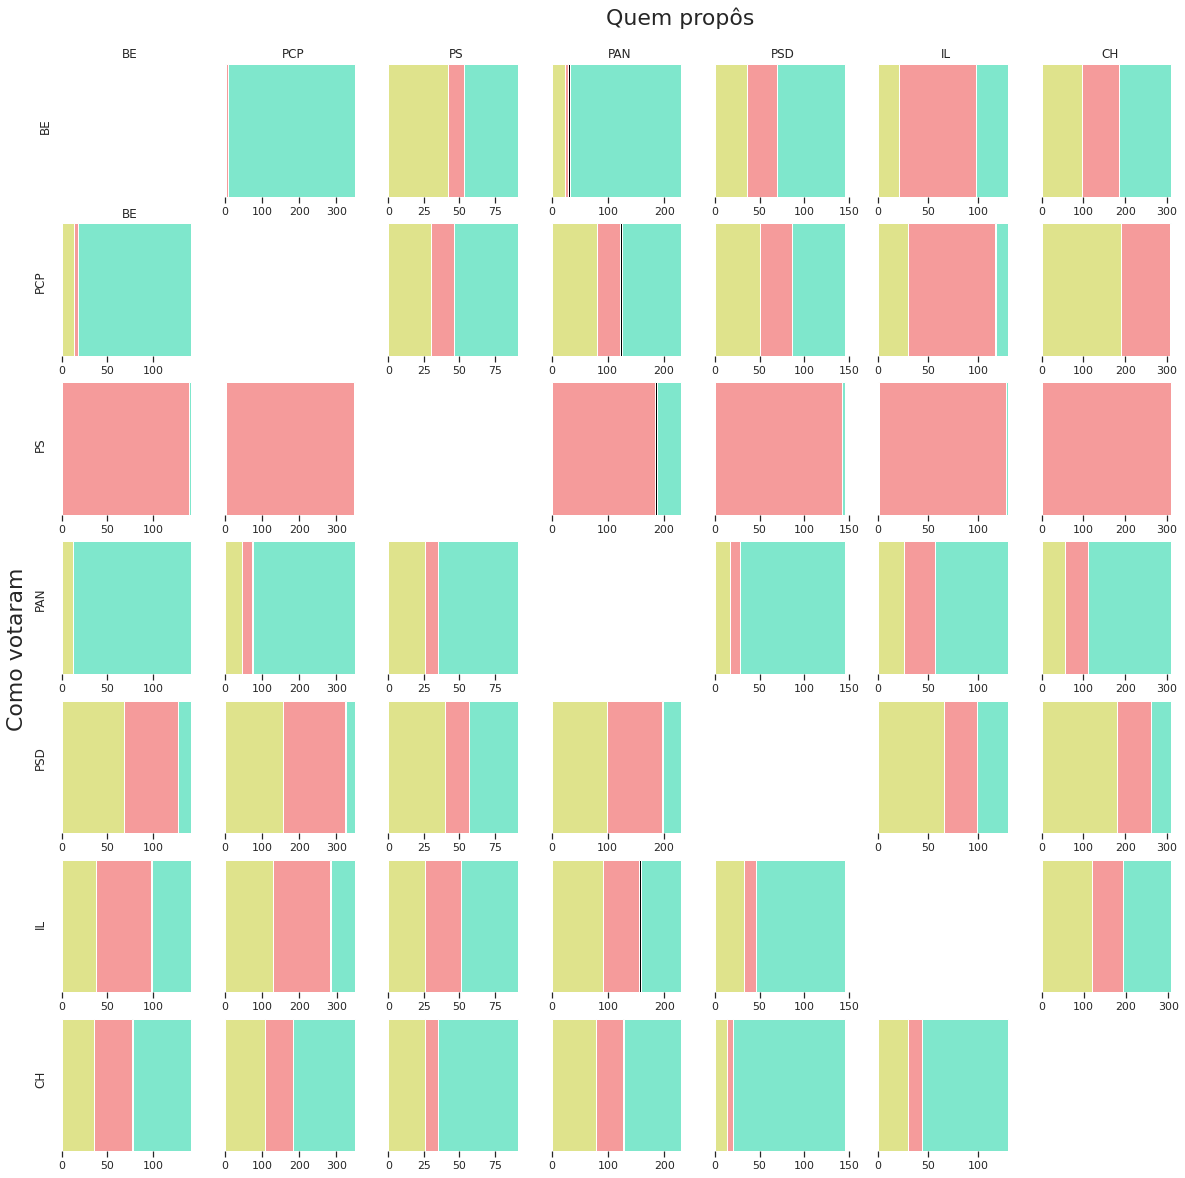

In [111]:
parties   = ['BE', 'PCP','PS', 'PAN','PSD', 'IL','CH']
gpsubs = submissions_ini

cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#DFE38C","#F59B9B","black","#7FE7CC" ]
cmap = ListedColormap(colors)

spn = 0
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(20, 20))
axes = axes.ravel()
for party in parties:
    for p2 in parties:
        sns.set_style("white")
        subp = gpsubs[gpsubs['GP'] == p2][[party]]
        sp = subp.fillna("Ausência").apply(pd.Series.value_counts)
        d = pd.DataFrame(columns=["GP","Abstenção", "Contra", "Ausência","Favor"]).merge(sp.T, how="right").fillna(0)
        d["GP"] = party
        d = d.set_index("GP")
        d = d[["Abstenção", "Contra", "Ausência","Favor"]]
        if p2 != party:
            sns.despine(left=True, bottom=True)
            if spn < 8:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap, title=p2,use_index=False,ax=axes[spn])
            else:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            axes[spn].get_legend().remove()
            plt.ylim(-4.5, axes[spn].get_yticks()[-1] + 0.5)
        else:
            axes[spn].set_xticks([])
            #d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            #axes[spn].get_legend().remove()
            if spn < 7:
                axes[spn].set_title(p2)
        axes[spn].set_yticks([])
        ## Why? Who knows? Certainly not me. This is likely a side-effect of using a single axis through .ravel
        if spn%7 == 0:
            if spn != 0:
                text = axes[spn].text(-30,0,party,rotation=90)
            else:
                text = axes[spn].text(-0.17,0.5,party,rotation=90)
        #print(party, p2)
        #print(d)
        #print("-------------------------_")
        spn += 1

#axes[11].set_axis_off()
text = axes[0].text(4,1.3,"Quem propôs",rotation=0,fontsize=22)
text = axes[0].text(-0.4,-4,"Como votaram",rotation=90,fontsize=22)

#fig.tight_layout()
plt.show()

Uma outra visualização, menos condensada mas com maior clareza quantitativa: para cada partido é criado um gráfico de barras, ordenado pelos votos favoráveis, com  comportamento de votos dos restantes para com as suas propostas. Incluimos aqui o Livre para que possa ser analisada a sua tendência de voto, apesar do número total ser, como se vê, significativamente inferior (algo que já tinhamos alertado para o OE 2021 em relação ao PEV).

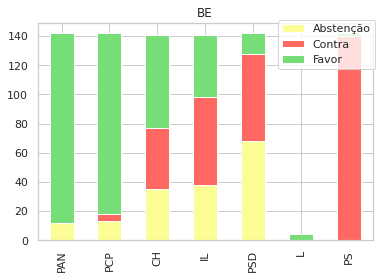

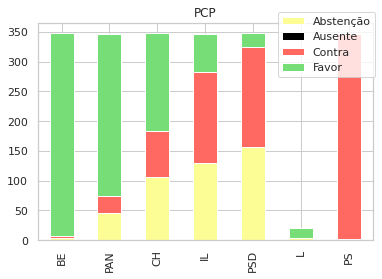

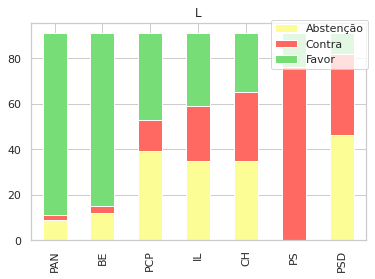

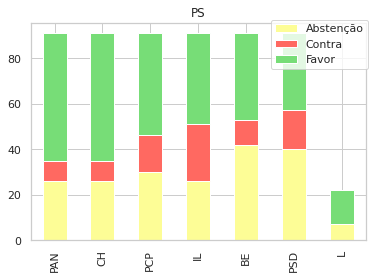

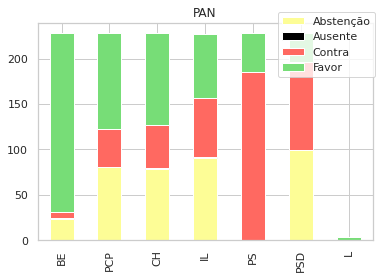

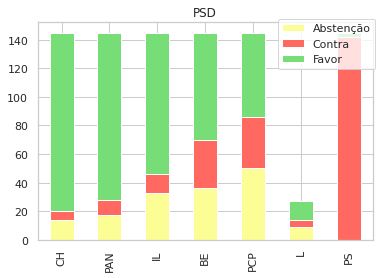

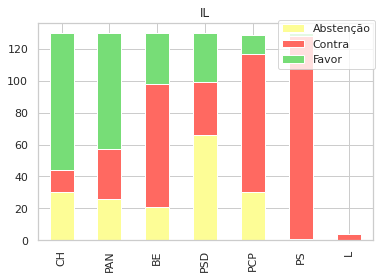

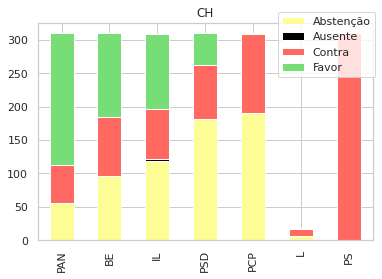

In [112]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
parties   = ['BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH']

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#fdfd96",  "black","#ff6961","#77dd77", ]
cmap = ListedColormap(colors)

#spn = 0
#axes = axes.ravel()

for party in parties:
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap,)
    plt.legend(loc='center left',  bbox_to_anchor=(0.7, 0.9),)
    plt.show()

plt.show()

## Dendograma e distância

Com base nas votações obtemos a distância euclideana entre todos os partidos (a distância entre todos os pares possíveis, considerado todas as votações), e com base nela um dendograma que indica a distância entre eles; note-se pelos diagramas acima que o número de votações do Livre é várias ordens de magnitude inferior aos restantes. A opção aqui foi removermos o Livre da análise por considerarmos que o resultado seria muito pouco representativo (e possivelmente enganador) - em todo o caso, é uma opção subjectiva.

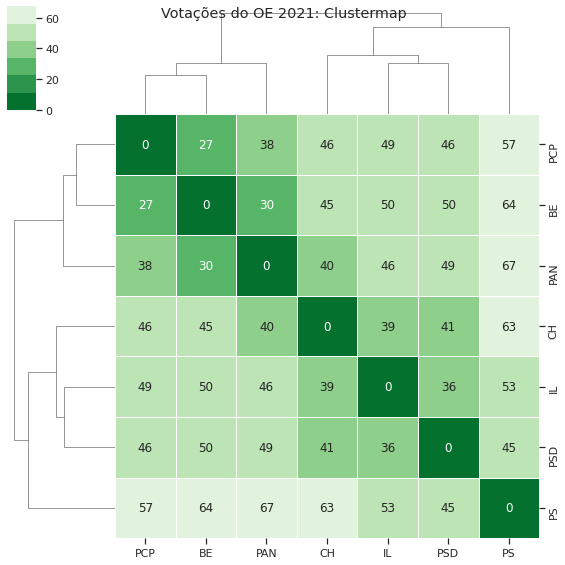

In [120]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import numpy as np
votes_hm = oe_dfr[['BE', 'PCP', 'PS', 'PAN', 'PSD','IL', 'CH']]
votes_hmn = votes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

## Affinity matrix
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)

#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Greens_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Votações do OE 2022: Clustermap')

plt.show()

```{margin} Votos idênticos vs. distância de votos

Por vezes o conceito de distância, votos idênticos e propostas aprovadas parece confuso. Adicionamos aqui o número de votos exactamente iguais. Estes dados são dos mais populares, talvez por serem muito directo na mensagem que transmitem.

Fica a ressalva: a consideração apenas dos votos "idênticos" desconsidera completamente a diferença entre votar Contra e Abstenção. Esta dimensão irá ser capturada na matriz de distâncias. Por outro lado, é também independente do número de propostas aprovadas: um partido pode estar mais "longe" (por ter votado mais vezes de forma diferente) e ter um número de propostas aprovada maior (por ter tido, nas suas propostas, a coincidência dos votos do PS, neste caso) do que um partido mais "próximo" (número de votações coincidentes maiores) mas que, nas propostas que fez, teve os votos contra do partido maioritário.
```

In [124]:
pv_list = []
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'font-weight: bold;')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv.style.apply(highlight_diag, axis=None)

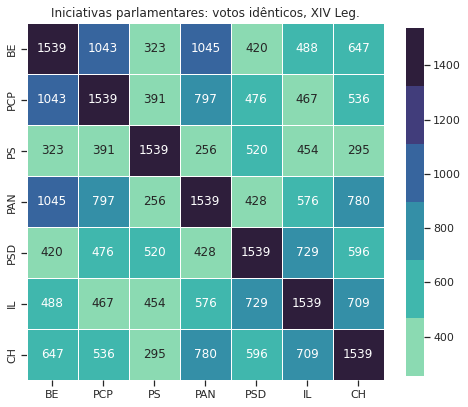

In [125]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Votação do OE 2022, votos idênticos.')

plt.show()

## MDS: *Multidimensional scaling*

Tendo como base os votos no OE podemos utilizar a mesma técnica que empregámos na análise de toda a legislatura. Para identificar grupos usamos (mais uma vez, como no trabalho original, e presente nos Apêndices) *Spectral scaling*, definindo 4 grupos.

```{margin} Votações por tema

Com base na identificação do "Tema" (_Domain_, no _dataframe_) pode-se verificar a proximidade (e _clustering_) em termos de cada tema; é necessário ter em conta a diferença (por vezes substancial) do número de votações de cada tema: existem temas com menos de 10 votações, e até com 1, o que produziria um número elevado de diagramas, razão pela qual excluímos os temas com menos de 10 votações.
```

In [103]:

for area in oe_df["Domain"].unique():
    varea=oe_dfr[oe_dfr["Domain"] == area]

    avotes_hm = varea[['BE', 'PCP' , 'PS', 'PAN', 'PSD','IL','CH']]
    avotes_hmn = avotes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0) 
    if avotes_hmn.shape[0] < 10:
        continue
    avotes_t = avotes_hmn.transpose()
    apwdist = pdist(avotes_t, metric='euclidean')
    
    adistmat = pd.DataFrame(
        squareform(apwdist), # pass a symmetric distance matrix
        columns = avotes_t.index,
        index = avotes_t.index)
    adistmat_mm=((adistmat-adistmat.min().min())/(adistmat.max().max()-adistmat.min().min()))*1
    
    aaffinmat_mm = pd.DataFrame(1-adistmat_mm, adistmat.index, adistmat.columns)

    asc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(aaffinmat_mm)
    asc_dict = dict(zip(adistmat,asc))   
    
    amds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
    aresults = amds.fit(adistmat_mm.values)
    acoords = aresults.embedding_
    
    sns.set()
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(8,8))

    plt.title(area + "(n=" + str(avotes_hmn.shape[0]) +  ")", fontsize=14, fontweight="bold")

    for label, x, y in zip(adistmat_mm.columns, acoords[:, 0], acoords[:, 1]):
        ax.scatter(x, y, c = "C"+str(asc_dict[label]), s=250)
        #ax.scatter(x, y, s=250)
        ax.axis('equal')
        ax.annotate(label,xy = (x-0.02, y+0.025))
    plt.show()
    print(asc_dict)

In [105]:
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

pd.DataFrame.from_dict(sc_dict, orient='index', columns=["Group"]).T

BE  PCP  PS  PAN  PSD  IL  CH
Group   1    1   0    1    2   2   2

O resultado aparente resultar numa divisão "esquerda/centro/direita", com o PS numa posição individual; tal como referido não será indiferente o facto do PS ser o partido que suporta o Governo, ainda para mais num contexto de maioria absoluta onde o PS é quase sempre o partido que mais vezes vota contra as propostas de qualquer partido. 

Esta separação pode ser vista também em termos de agrupamento e proximidade relativa:

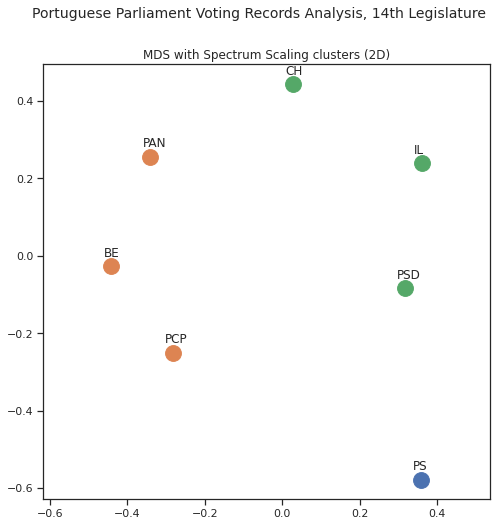

In [117]:
from sklearn.manifold import MDS
import random
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2022, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('2022 Budget Approval', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

Este mapa é bastante semelhante do do OE anterior, com uma separação esquerda/direita com o PS a uma distância semelhante de ambos os grupos.

Uma visualização em 3D permtie uma visão diferente, com mais uma dimensão:

In [41]:
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 700,
    height = 700,
    title = "OE 2021: 3D MDS",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
plot(fig, filename = 'oe_3d_mds.html')
display(HTML('oe_3d_mds.html'))

## Palavras finais


Esta análise demonstra como a utilização de dados abertos pode, uma vez mais, facilitar a análise da actividade parlamentar por parte dos eleitores; as ilações políticas que se podem tirar são variadas e, se é verdade que existem limitações várias a ter em conta, tal como no trabalho relativo à análise das votações parlamentares parecem emergir padrões que parecem reflectir tendências e agrupamentos que estão presentes no discurso político.

Sugere-se uma leitura comparada da análise feita, exactamente nos mesmos moldes, para o OE de 2021: se aqui e ali formos fazendo referências ao que mudou e se manteve, mais há por explorar nessa dimensão comparativa.